เราจะมาลองเทรน 2 โมเดล เปรียบเทียบโมเดล ที่ใช้ Data Augmentation และไม่ใช้ ว่า Validation Loss จะต่างกันอย่างไร

# 0. Magic Commands


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

In [0]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy

# 2. ข้อมูล



เราจะใช้ Dataset [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) จำแนกพันธุ์หมาแมวเหมือนดิม

In [0]:
path = untar_data(URLs.PETS)
path_images = path/'images'
filenames = get_image_files(path_images)

ประกาศฟัง์ชัน สร้าง databunch และฟังก์ชันแสดงภาพ เราจะ Sample ข้อมูลมาแค่ 500 ตัวอย่าง

In [0]:
def get_databunch(transform):
    batchsize = 32
    sample = 5000
    np.random.seed(555)
    regex_pattern = r'/([^/]+)_\d+.jpg$'

    return ImageDataBunch.from_name_re(path_images, 
                                       random.sample(filenames, sample), 
                                       regex_pattern, 
                                       ds_tfms=transform, 
                                       size=224, bs=batchsize).normalize(imagenet_stats)

def get_ex(): return open_image(f'{path_images}/pug_147.jpg')

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(transform[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

# 3. เตรียมข้อมูล

เราจะไปสร้าง DataBunch พร้อมสร้างโมเดลจะได้สะดวกในการเปรียบเทียบ

# 4. สร้างโมเดล



ในเคสนี้ เราจะใช้โมเดลที่ไม่ใหม่มาก ไม่มี Skip Connection อย่าง VGG และไม่ใช้ Dropout (ps=0.0), Weight Decay (wd=0.0) จะได้เปรียบเทียบได้ชัด ๆ

## ไม่ใช้ Data Augmentation

ปิด Data Augmentaion ทุกอย่าง ด้วย Empty List 2 อัน คือ transform สำหรับ Training Set และ Validation Set

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:06<00:00, 84022164.53it/s]


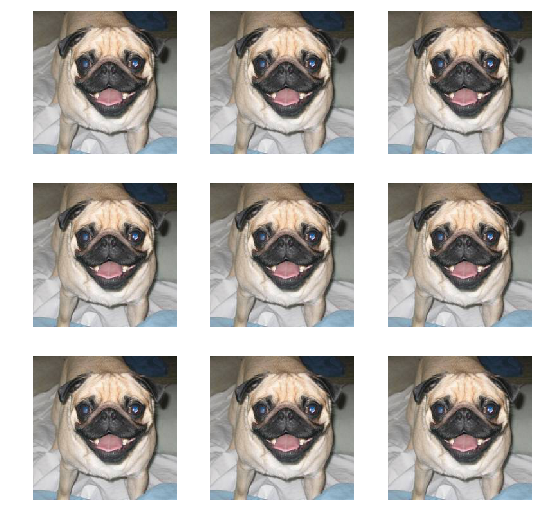

In [5]:
transform = ([], [])
databunch = get_databunch(transform)
learner = cnn_learner(databunch, models.vgg16_bn, ps=0.0, wd=0.0, 
                      metrics=accuracy, callback_fns=ShowGraph)#.to_fp16()
plots_f(3, 3, 9, 9, size=224)

epoch,train_loss,valid_loss,accuracy,time
0,0.655079,0.405314,0.876000,00:59


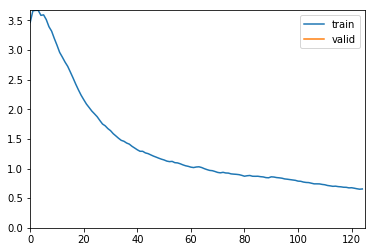

In [6]:
learner.fit_one_cycle(1, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.236493,0.314659,0.896000,01:18
1,0.205747,0.426821,0.868000,01:16
2,0.173575,0.529273,0.854000,01:16
3,0.091664,0.421931,0.882000,01:16
4,0.034963,0.350506,0.898000,01:16
5,0.023417,0.338753,0.909000,01:16
6,0.007262,0.330675,0.913000,01:16
7,0.003021,0.330944,0.912000,01:16


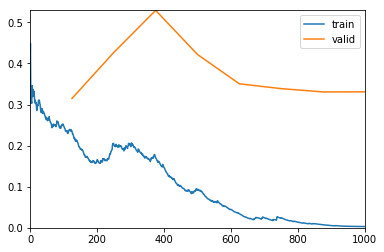

In [7]:
learner.unfreeze()
learner.fit_one_cycle(8, max_lr=slice(3e-6, 3e-3))

เคลียร์ Memory

In [8]:
learner = None
gc.collect()

23212

## ใช้ Data Augmentation
เปิด Data Augmentaion ทุกอย่าง

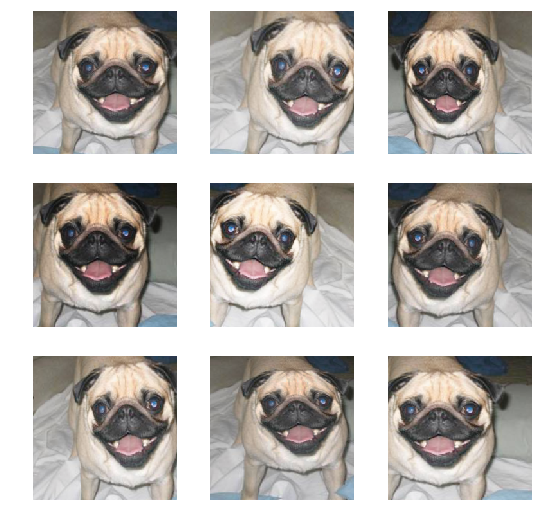

In [9]:
# transform = get_transform()
transform = get_transforms(do_flip=True, flip_vert=False, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)
databunch = get_databunch(transform)
learner = cnn_learner(databunch, models.vgg16_bn, ps=0.0, wd=0.0, 
                      metrics=accuracy, callback_fns=ShowGraph)#.to_fp16()
plots_f(3, 3, 9, 9, size=224)

epoch,train_loss,valid_loss,accuracy,time
0,0.754036,0.398110,0.869000,01:11


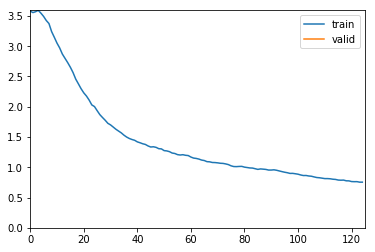

In [10]:
learner.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.337470,0.307922,0.899000,01:19
1,0.348062,0.497171,0.846000,01:18
2,0.305466,0.391889,0.886000,01:17
3,0.197134,0.349613,0.893000,01:18
4,0.139096,0.336036,0.903000,01:18
5,0.080044,0.274923,0.922000,01:17
6,0.045640,0.267692,0.921000,01:18
7,0.032543,0.268580,0.925000,01:17


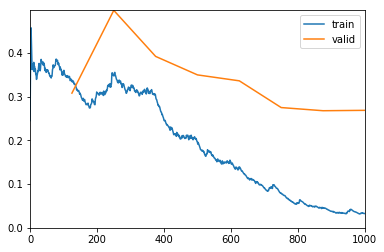

In [11]:
learner.unfreeze()
learner.fit_one_cycle(8, max_lr=slice(3e-6, 3e-3))

# 5. สรุป


1. โมเดลที่ไม่ได้ใช้ Data Augmentation เทรนไปหลาย Epoch แล้ว Training Loss ลดลงเรื่อย ๆ แต่ Validation Loss กลับไม่ลดลง และ Accuracy ก็ไม่ได้ดีขึ้น เป็นสัญญาณของ Overfit 
2. โมเดลที่ใช้ Data Augmentation เทรนไปด้วยจำนวน Epoch เท่ากัน Training Loss ลดลงเรื่อย ๆ พร้อมกับ Validation Loss และ Accuracy ก็ดีขึ้นเรื่อย ๆ ไม่ Overfit
3. โมเดลสมัยใหม่ ออกแบบมาค่อนข้างดี ทำให้ Overfit ค่อนข้างยาก

# Credit 

* [Data Augmentation | How to use Deep Learning when you have Limited Data — Part 2](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
* [vision.transform](https://docs.fast.ai/vision.transform.html#get_transforms)
*  [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)
* [FastAI: Practical Deep Learning for Coders, v3 - Lesson 1](https://course.fast.ai/videos/?lesson=1)
